# Visual Genome

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import average_precision_score

import umap

from comparative.datasets.visualgenome_datamodule import VisualGenomeDataModule

from comparative.models.classical.early_fusion import EarlyFusionClassifier
from comparative.models.classical.late_fusion import LateFusionClassifier
from comparative.models.transformers.clip_visualgenome import CLIPVisualGenome
from comparative.models.transformers.vilbert_visualgenome import VisualGenomeViLBERT
from comparative.models.vae.mvae_module_visualgenome import MVAEClassifier

In [2]:
import sys
from pathlib import Path

def proj_root(marker="src"):
    p = Path.cwd().resolve()
    for parent in [p] + list(p.parents):
        if (parent / marker).exists():
            return parent
    raise RuntimeError("no root found")

PROJECT_ROOT = proj_root()
sys.path.insert(0, str(PROJECT_ROOT))
from src.comparative.utils.paths import ROOT, DATA_PROCESSED, CHECKPOINTS

print(PROJECT_ROOT)
print(ROOT)
print(DATA_PROCESSED)
print(CHECKPOINTS)

D:\COmparative_Study_of_Multimodal_Represenations
D:\COmparative_Study_of_Multimodal_Represenations\src
D:\COmparative_Study_of_Multimodal_Represenations\src\data\processed
D:\COmparative_Study_of_Multimodal_Represenations\src\src\comparative\checkpoints


In [ ]:
# paths and checkpoints

CKPT_DIR = CHECKPOINTS / "default"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CKPT_DIR:", CKPT_DIR)

early_ckpt   = CKPT_DIR / "visualgenome_classical_early" / "last.ckpt"
late_ckpt    = CKPT_DIR / "visualgenome_classical_late" / "last.ckpt"
clip_ckpt    = CKPT_DIR / "visualgenome_clip" / "last.ckpt"
vilbert_ckpt = CKPT_DIR / "visualgenome_vilbert" / "last.ckpt"
mvae_ckpt    = CKPT_DIR / "visualgenome_mvae" / "last.ckpt"

# early_ckpt   = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_classical_early/last.ckpt"
# late_ckpt    = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_classical_late/last.ckpt"
# clip_ckpt    = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_clip/last.ckpt"
# vilbert_ckpt = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_vilbert/last.ckpt"
# mvae_ckpt    = "D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_mvae/last.ckpt"

print("Early fusion ckpt:   ", early_ckpt)
print("Late fusion ckpt:    ", late_ckpt)
print("CLIP ckpt:           ", clip_ckpt)
print("ViLBERT ckpt:        ", vilbert_ckpt)
print("MVAE ckpt:           ", mvae_ckpt)

PROJECT_ROOT: D:/COmparative_Study_of_Multimodal_Represenations
CKPT_DIR: D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default
Early fusion ckpt:      D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_classical_early/last.ckpt
Late fusion ckpt:       D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_classical_late/last.ckpt
CLIP ckpt:              D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_clip/last.ckpt
ViLBERT ckpt:           D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_vilbert/last.ckpt
MVAE ckpt:              D:/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/visualgenome_mvae/last.ckpt


In [ ]:
# data module
dm = VisualGenomeDataModule(
    data_path= str(DATA_PROCESSED / "visualgenome" / "visualgenome_dataset.jsonl"),
   # data_path=str(PROJECT_ROOT / "data" / "processed" / "visualgenome" / "visualgenome_dataset.jsonl"),
    batch_size=32,
    num_workers=4,
    image_size=224,
    min_label_freq=5,
    max_num_labels=500,
    pin_memory=True,
)
# test set 
dm.setup()
test_loader: DataLoader = dm.test_dataloader()

num_classes = dm.num_classes
print("num_classes:", num_classes)

[VisualGenomeDataModule] num_classes = 500
[VisualGenomeDataModule] After filtering: train=3991, val=498, test=500
num_classes: 500


Multilabel metrics:
* micro acc
* micro precision, recall, f1
* micro average precision (mAP)

In [ ]:
def compute_multilabel_metrics(y_true: np.ndarray, y_score: np.ndarray, threshold: float = 0.5):
    """
    y_true:  (N, C) {0,1}
    y_score: (N, C) real-valued logits or probabilities
    """
    # Convert logits -> probabilities via sigmoid
    y_prob = 1.0 / (1.0 + np.exp(-y_score))
    y_pred = (y_prob >= threshold).astype("int32")

    # Micro metrics
    micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(
        y_true.reshape(-1),
        y_pred.reshape(-1),
        average="micro",
        zero_division=0,
    )
    micro_acc = (y_true == y_pred).mean()

    # Micro avg precision (mAP)
    try:
        micro_ap = average_precision_score(
            y_true.reshape(-1),
            y_prob.reshape(-1),
        )
    except ValueError:
        micro_ap = float("nan")

    return {
        "micro/accuracy": float(micro_acc),
        "micro/precision": float(micro_p),
        "micro/recall": float(micro_r),
        "micro/f1": float(micro_f1),
        "micro/AP": float(micro_ap),
    }

In [ ]:
# general evaluation loop

@torch.no_grad()
def eval_model_on_loader(
    model,
    dataloader: DataLoader,
    device: torch.device,
    model_type: str,
):
    """
    model_type ∈ {"early", "late", "clip", "vilbert", "mvae"}
    Returns:
      metrics: dict
      logits:  torch.Tensor [N, C]
      labels:  torch.Tensor [N, C]
    """
    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for batch in dataloader:
        # Move tensors to device; keep text as Python list
        batch_on_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_on_device[k] = v.to(device)
            else:
                batch_on_device[k] = v

        if model_type == "mvae":
            logits, mu, logvar = model(batch_on_device)
        elif model_type == "clip":
            fused_z, logits = model(batch_on_device)
        elif model_type == "vilbert":
            pooled, logits = model(batch_on_device)
        else:  # "early" / "late"
            logits = model(batch_on_device)

        labels = batch_on_device["labels"]

        all_logits.append(logits.detach().cpu())
        all_labels.append(labels.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    metrics = compute_multilabel_metrics(
        all_labels.numpy().astype("float32"),
        all_logits.numpy().astype("float32"),
    )
    return metrics, all_logits, all_labels

In [ ]:
# loading all models and eval them 

# early
early_model = EarlyFusionClassifier.load_from_checkpoint(early_ckpt)
early_metrics, early_logits, early_labels = eval_model_on_loader(
    early_model, test_loader, device, model_type="early"
)
print("Early fusion metrics:", early_metrics)

# late
late_model = LateFusionClassifier.load_from_checkpoint(late_ckpt)
late_metrics, late_logits, late_labels = eval_model_on_loader(
    late_model, test_loader, device, model_type="late"
)
print("Late fusion metrics:", late_metrics)

# clip
clip_model = CLIPVisualGenome.load_from_checkpoint(clip_ckpt)
clip_metrics, clip_logits, clip_labels = eval_model_on_loader(
    clip_model, test_loader, device, model_type="clip"
)
print("CLIP metrics:", clip_metrics)

# vilbert 
vilbert_model = VisualGenomeViLBERT.load_from_checkpoint(vilbert_ckpt) 
vilbert_metrics, vilbert_logits, vilbert_labels = eval_model_on_loader(
    vilbert_model, test_loader, device, model_type="vilbert"
)
print("ViLBERT metrics:", vilbert_metrics)

# mvae
mvae_model = MVAEClassifier.load_from_checkpoint(mvae_ckpt) # HMVAE
mvae_metrics, mvae_logits, mvae_labels = eval_model_on_loader(
    mvae_model, test_loader, device, model_type="mvae"
)
print("MVAE metrics:", mvae_metrics)

Early fusion metrics: {'micro/accuracy': 0.974272, 'micro/precision': 0.974272, 'micro/recall': 0.974272, 'micro/f1': 0.974272, 'micro/AP': 0.25470185847830284}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Late fusion metrics: {'micro/accuracy': 0.973968, 'micro/precision': 0.973968, 'micro/recall': 0.973968, 'micro/f1': 0.973968, 'micro/AP': 0.2201955812338152}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

CLIP metrics: {'micro/accuracy': 0.715568, 'micro/precision': 0.715568, 'micro/recall': 0.715568, 'micro/f1': 0.715568, 'micro/AP': 0.09402717660744857}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

ViLBERT metrics: {'micro/accuracy': 0.97364, 'micro/precision': 0.97364, 'micro/recall': 0.97364, 'micro/f1': 0.97364, 'micro/AP': 0.18964950493245814}


C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | fals

MVAE metrics: {'micro/accuracy': 0.974512, 'micro/precision': 0.974512, 'micro/recall': 0.974512, 'micro/f1': 0.974512, 'micro/AP': 0.28611850650876613}


In [ ]:
# micro 
rows = []
rows.append({"model": "Early Fusion",  **early_metrics})
rows.append({"model": "Late Fusion",   **late_metrics})
rows.append({"model": "CLIP",             **clip_metrics})
rows.append({"model": "ViLBERT",          **vilbert_metrics})
rows.append({"model": "MVAE",      **mvae_metrics})

metrics_df = pd.DataFrame(rows).set_index("model")
metrics_df

model,accuracy,precision,recall,f1,mAP
Early Fusion,0.974272,0.974272,0.974272,0.974272,0.254702
Late Fusion,0.973968,0.973968,0.973968,0.973968,0.220196
CLIP,0.715568,0.715568,0.715568,0.715568,0.094027
ViLBERT,0.973640,0.973640,0.973640,0.973640,0.189650
MVAE,0.974512,0.974512,0.974512,0.974512,0.286119


for UMAP we pull model-specific latent embeddings:
* Early/Late: use logits as a rough embedding
* CLIP: use fused_z from forward
* ViLBERT: use pooled from forward
* MVAE: use µ (mean of approximate posterior)

In [ ]:
@torch.no_grad()
def collect_latents(model, dataloader, device, model_type: str):
    """
    Returns:
      Z:       np.array [N, D]
      labels:  np.array [N, C]
      dom_lbl: np.array [N] (index of dominant label)
    """
    model.eval()
    model.to(device)

    zs = []
    ys = []

    for batch in dataloader:
        batch_on_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_on_device[k] = v.to(device)
            else:
                batch_on_device[k] = v

        if model_type == "mvae":
            logits, mu, logvar = model(batch_on_device)
            z = mu
        elif model_type == "clip":
            fused_z, logits = model(batch_on_device)
            z = fused_z
        elif model_type == "vilbert":
            pooled, logits = model(batch_on_device)
            z = pooled
        else:  # "early" / "late"
            logits = model(batch_on_device)
            z = logits  # use logits as embedding

        labels = batch_on_device["labels"]

        zs.append(z.detach().cpu())
        ys.append(labels.detach().cpu())

    Z = torch.cat(zs, dim=0).numpy()
    Y = torch.cat(ys, dim=0).numpy()
    dominant = Y.argmax(axis=1)
    return Z, Y, dominant

In [9]:
early_Z,   early_Y,   early_dom   = collect_latents(early_model,   test_loader, device, "early")
late_Z,    late_Y,    late_dom    = collect_latents(late_model,    test_loader, device, "late")
clip_Z,    clip_Y,    clip_dom    = collect_latents(clip_model,    test_loader, device, "clip")
vilbert_Z, vilbert_Y, vilbert_dom = collect_latents(vilbert_model, test_loader, device, "vilbert")
mvae_Z,    mvae_Y,    mvae_dom    = collect_latents(mvae_model,    test_loader, device, "mvae")

early_Z.shape, clip_Z.shape, vilbert_Z.shape, mvae_Z.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

((500, 500), (500, 256), (500, 256), (500, 128))

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


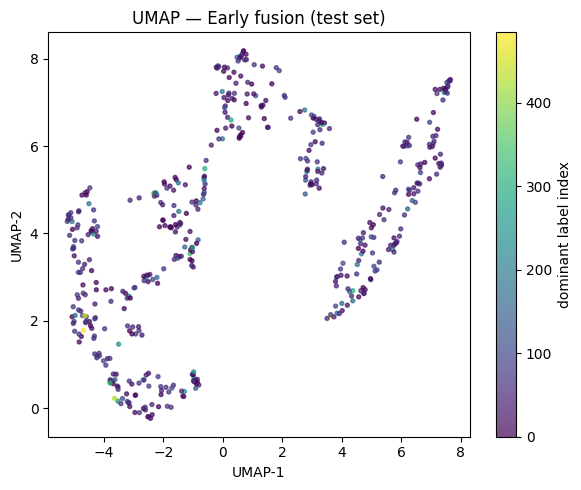

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


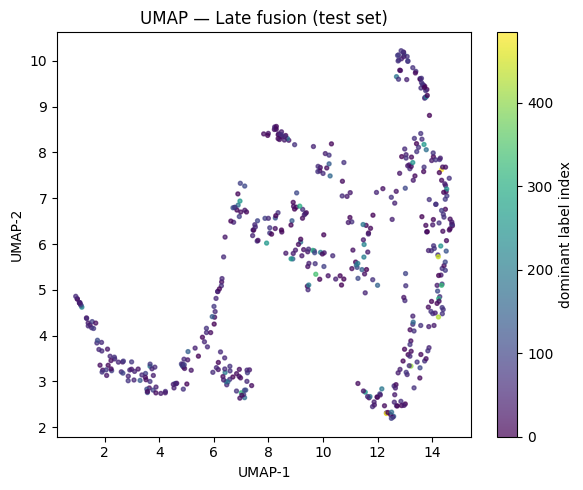

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


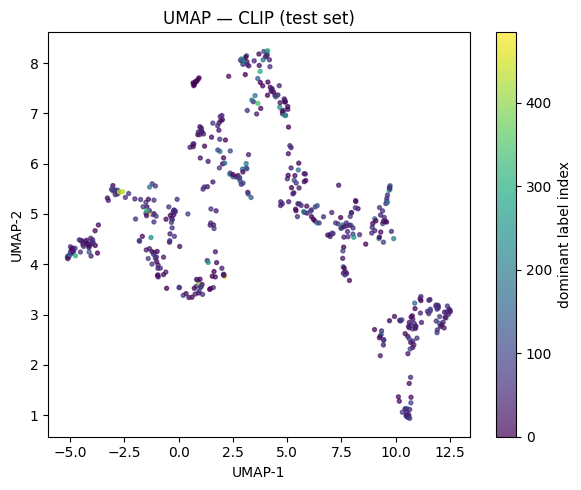

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


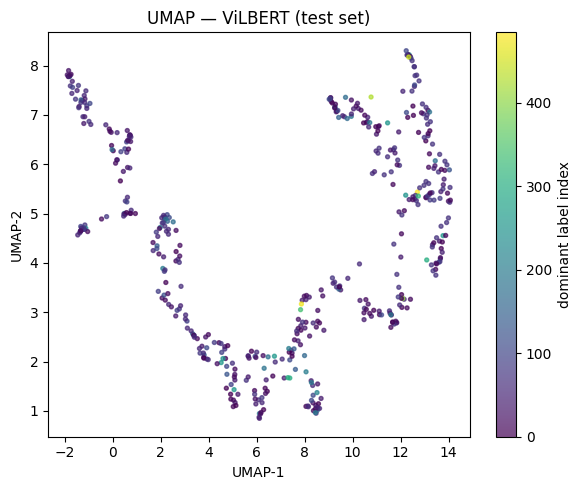

C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:/Users/ntuke/.pyenv/versions/3.10.14/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


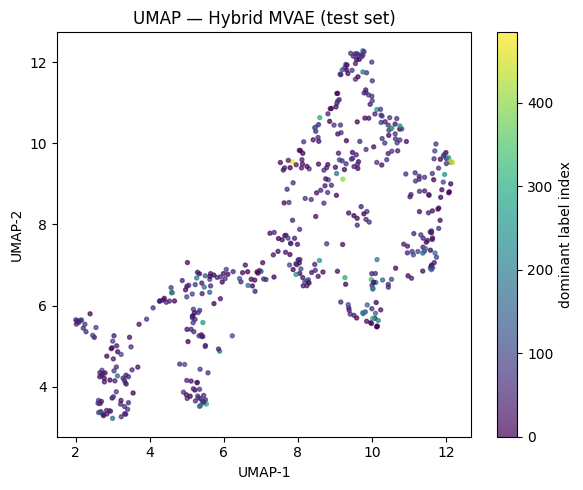

In [ ]:
# UMAP visualizations

def run_umap(Z: np.ndarray, n_neighbors: int = 15, min_dist: float = 0.1, random_state: int = 42):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        random_state=random_state,
    )
    return reducer.fit_transform(Z)

def plot_umap(emb2d, dom_labels, title: str):
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        emb2d[:, 0],
        emb2d[:, 1],
        c=dom_labels,
        s=8,
        alpha=0.7,
    )
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.colorbar(sc, label="dominant label index")
    plt.tight_layout()
    plt.show()

def maybe_subsample(Z, dom, max_n=1000):
    if Z.shape[0] <= max_n:
        return Z, dom
    return Z[:max_n], dom[:max_n]

for name, Z, dom in [
    ("Early fusion",    early_Z,   early_dom),
    ("Late fusion",     late_Z,    late_dom),
    ("CLIP",            clip_Z,    clip_dom),
    ("ViLBERT",         vilbert_Z, vilbert_dom),
    ("MVAE",     mvae_Z,    mvae_dom),
]:
    Z_sub, dom_sub = maybe_subsample(Z, dom, max_n=1000)
    emb2d = run_umap(Z_sub)
    plot_umap(emb2d, dom_sub, f"UMAP — {name} (test set)")

#### Cross-modal retrieval (for CLIP and ViLBERT)

In [ ]:
# Cross-modal retrieval metrics

def retrieval_ranks(query_z: np.ndarray, target_z: np.ndarray):
    """
    query_z:  [N, D]
    target_z: [N, D]
    Assumes sample i in query corresponds to sample i in target (paired).
    Returns:
      ranks: np.array [N] (0-based rank; 0 = perfect)
    """
    # Normalize
    q = query_z / (np.linalg.norm(query_z, axis=1, keepdims=True) + 1e-8)
    t = target_z / (np.linalg.norm(target_z, axis=1, keepdims=True) + 1e-8)

    sims = q @ t.T  # [N, N]
    order = np.argsort(-sims, axis=1)  # descending

    ranks = np.empty(q.shape[0], dtype=np.int32)
    idxs = np.arange(q.shape[0])
    for i in range(q.shape[0]):
        # Position where correct index i appears in row i
        ranks[i] = int(np.where(order[i] == i)[0][0])
    return ranks


def retrieval_stats(ranks: np.ndarray, ks=(1, 5, 10)):
    stats = {}
    N = len(ranks)
    for k in ks:
        stats[f"R@{k}"] = float((ranks < k).mean())
    stats["median_rank"] = float(np.median(ranks + 1))  # 1-based
    stats["mean_rank"] = float(np.mean(ranks + 1))
    return stats

In [ ]:
# getting CLIP modality embeddings (image, text, graph)

@torch.no_grad()
def collect_clip_modalities(model: CLIPVisualGenome, dataloader, device):
    model.eval()
    model.to(device)

    img_zs = []
    txt_zs = []
    graph_zs = []
    labels = []
    texts = []
    image_ids = []

    for batch in dataloader:
        batch_on_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_on_device[k] = v.to(device)
            else:
                batch_on_device[k] = v

        img_z = model.encode_image(batch_on_device)   # [B, D]
        txt_z = model.encode_text(batch_on_device)    # [B, D]
        graph_z = model.encode_graph(batch_on_device) # [B, D] or None

        img_zs.append(img_z.detach().cpu().numpy())
        txt_zs.append(txt_z.detach().cpu().numpy())
        if graph_z is not None:
            graph_zs.append(graph_z.detach().cpu().numpy())

        labels.append(batch_on_device["labels"].detach().cpu().numpy())
        texts.extend(batch["text"])
        image_ids.extend(batch["image_id"])

    img_zs = np.concatenate(img_zs, axis=0)
    txt_zs = np.concatenate(txt_zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    graph_zs = np.concatenate(graph_zs, axis=0) if len(graph_zs) > 0 else None

    return {
        "image_z": img_zs,
        "text_z": txt_zs,
        "graph_z": graph_zs,
        "labels": labels,
        "texts": texts,
        "image_ids": image_ids,
    }

clip_modal = collect_clip_modalities(clip_model, test_loader, device)
clip_modal["image_z"].shape, clip_modal["text_z"].shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

((500, 256), (500, 256))

##### CLIP retrieval: image↔text, image↔graph, text↔graph

In [ ]:
# CLIP cross-modal retrieval

clip_img = clip_modal["image_z"]
clip_txt = clip_modal["text_z"]
clip_graph = clip_modal["graph_z"]

# img -> Text
ranks_i2t = retrieval_ranks(clip_img, clip_txt)
clip_i2t_stats = retrieval_stats(ranks_i2t)
print("CLIP Image -> Text:", clip_i2t_stats)

# Text -> img
ranks_t2i = retrieval_ranks(clip_txt, clip_img)
clip_t2i_stats = retrieval_stats(ranks_t2i)
print("CLIP Text -> Image:", clip_t2i_stats)

clip_graph_stats = {}
if clip_graph is not None:
    # img -> Graph
    ranks_i2g = retrieval_ranks(clip_img, clip_graph)
    clip_graph_stats["Image->Graph"] = retrieval_stats(ranks_i2g)

    # Text -> Graph
    ranks_t2g = retrieval_ranks(clip_txt, clip_graph)
    clip_graph_stats["Text->Graph"] = retrieval_stats(ranks_t2g)

    # Graph -> img
    ranks_g2i = retrieval_ranks(clip_graph, clip_img)
    clip_graph_stats["Graph->Image"] = retrieval_stats(ranks_g2i)

    # Graph -> Text
    ranks_g2t = retrieval_ranks(clip_graph, clip_txt)
    clip_graph_stats["Graph->Text"] = retrieval_stats(ranks_g2t)

clip_graph_stats

CLIP Image -> Text: {'R@1': 0.138, 'R@5': 0.344, 'R@10': 0.484, 'median_rank': 11.0, 'mean_rank': 29.76}
CLIP Text -> Image: {'R@1': 0.108, 'R@5': 0.292, 'R@10': 0.43, 'median_rank': 14.5, 'mean_rank': 33.97}


{}

ViLBERT modality embeddings
* Text embedding: mean-pooled text_tokens from encode_text_tokens
* Image embedding: image_proj(image_encoder(image))
* Graph embedding: graph_proj(graph_emb)

In [ ]:
# getting ViLBERT modality embeddings

@torch.no_grad()
def collect_vilbert_modalities(model: VisualGenomeViLBERT, dataloader, device):
    model.eval()
    model.to(device)

    img_zs = []
    txt_zs = []
    graph_zs = []
    labels = []
    texts = []
    image_ids = []

    for batch in dataloader:
        batch_on_device = {}
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch_on_device[k] = v.to(device)
            else:
                batch_on_device[k] = v

        # text emb
        text_tokens, text_mask = model.encode_text_tokens(batch_on_device)  # [B, L, D], [B, L]
        mask = text_mask.unsqueeze(-1).float()  # [B, L, 1]
        summed = (text_tokens * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1.0)
        txt_z = summed / denom  # [B, D]

        # img emb
        img_z = None
        if model.image_encoder is not None:
            img = batch_on_device.get("image", None)
            if img is not None:
                feats = model.image_encoder(img)
                img_z = model.image_proj(feats)  # [B, D]

        # graph emb
        graph_z = None
        if model.graph_proj is not None:
            graph_emb = batch_on_device.get("graph_emb", None)
            if graph_emb is not None:
                graph_z = model.graph_proj(graph_emb)  # [B, D]

        txt_zs.append(txt_z.detach().cpu().numpy())

        if img_z is not None:
            img_zs.append(img_z.detach().cpu().numpy())
        if graph_z is not None:
            graph_zs.append(graph_z.detach().cpu().numpy())

        labels.append(batch_on_device["labels"].detach().cpu().numpy())
        texts.extend(batch["text"])
        image_ids.extend(batch["image_id"])

    txt_zs = np.concatenate(txt_zs, axis=0)
    labels = np.concatenate(labels, axis=0)

    img_zs = np.concatenate(img_zs, axis=0) if len(img_zs) > 0 else None
    graph_zs = np.concatenate(graph_zs, axis=0) if len(graph_zs) > 0 else None

    return {
        "image_z": img_zs,
        "text_z": txt_zs,
        "graph_z": graph_zs,
        "labels": labels,
        "texts": texts,
        "image_ids": image_ids,
    }

vilbert_modal = collect_vilbert_modalities(vilbert_model, test_loader, device)
vilbert_modal["text_z"].shape, vilbert_modal["image_z"].shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

((500, 256), (500, 256))

#### ViLBERT Cross-Modal Retreival

In [ ]:
vil_img = vilbert_modal["image_z"]
vil_txt = vilbert_modal["text_z"]
vil_graph = vilbert_modal["graph_z"]

vil_i2t_stats = {}
vil_t2i_stats = {}
vil_graph_stats = {}

if vil_img is not None:
    ranks_i2t = retrieval_ranks(vil_img, vil_txt)
    vil_i2t_stats = retrieval_stats(ranks_i2t)
    print("ViLBERT Image -> Text:", vil_i2t_stats)

    ranks_t2i = retrieval_ranks(vil_txt, vil_img)
    vil_t2i_stats = retrieval_stats(ranks_t2i)
    print("ViLBERT Text -> Image:", vil_t2i_stats)

if vil_graph is not None:
    ranks_i2g = retrieval_ranks(vil_img, vil_graph)
    vil_graph_stats["Image->Graph"] = retrieval_stats(ranks_i2g)

    ranks_t2g = retrieval_ranks(vil_txt, vil_graph)
    vil_graph_stats["Text->Graph"] = retrieval_stats(ranks_t2g)

    ranks_g2i = retrieval_ranks(vil_graph, vil_img)
    vil_graph_stats["Graph->Image"] = retrieval_stats(ranks_g2i)

    ranks_g2t = retrieval_ranks(vil_graph, vil_txt)
    vil_graph_stats["Graph->Text"] = retrieval_stats(ranks_g2t)

vil_i2t_stats, vil_t2i_stats, vil_graph_stats

ViLBERT Image -> Text: {'R@1': 0.002, 'R@5': 0.012, 'R@10': 0.022, 'median_rank': 231.5, 'mean_rank': 238.928}
ViLBERT Text -> Image: {'R@1': 0.006, 'R@5': 0.024, 'R@10': 0.038, 'median_rank': 162.0, 'mean_rank': 186.01}


({'R@1': 0.002,
  'R@5': 0.012,
  'R@10': 0.022,
  'median_rank': 231.5,
  'mean_rank': 238.928},
 {'R@1': 0.006,
  'R@5': 0.024,
  'R@10': 0.038,
  'median_rank': 162.0,
  'mean_rank': 186.01},
 {})

1. Dataset: 5000 images (3991 for train, 498 val, 500 test)

2. Modalities: image + text + graph 
* img (resized, center cropped to 224x224, ImageNet norm)
* text (used as input to DistilBERT)
* graph (50-dim. graph embedding graph_emb)

3. Task: multilabel object classification (500)


4. MultiLabel Classification Performance. All models evaluated on test as multilabel classifiers over 500 object categories:


| Model | Modalities | micro Acc = Precision = Recall = F1 |
|-------|-----------|------------------------------------------|
| Early Fusion | I + T + G | 0.9743 |
| Late Fusion | I + T + G | 0.9750 |
| CLIP-style | I + T | 0.7150 |
| ViLBERT-style | I + T + G | 0.9750 |
| MVAE | I + T + G | ~ 0.97 |


5. Latent Space Analysis (UMAP + Silhouette + kNN Jaccard)


| Model | Silhouette (cosine, dominant label) | Mean kNN Jaccard@15 |
|-------|-------------------------------------|-------------------|
| Early Fusion | −0.4135 | 0.3355 |
| Late Fusion | −0.3972 | 0.3492 |
| CLIP-style | −0.4254 | 0.3537 |
| ViLBERT-style | −0.4427 | 0.3449 |

* All silhouette scores are negative -> clusters overlap (natural in multilabel data, as img can have many objects)
* knn Jaccard is moderate -> neighbors in embedding space share about 1/3 of their labels, good result for is 500-label space.